<a href="https://colab.research.google.com/github/tanvik7/Stock-market-prediction/blob/main/STOCK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade mplfinance pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

# Import Decision Tree and ARIMA libraries
from sklearn.tree import DecisionTreeRegressor
from pmdarima import auto_arima

In [ ]:
df = pd.read_csv('/content/stocks.csv', parse_dates=['Date'])
df.head()

# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Stock'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

# Selecting any random company out of our 'Name' column
company_name = random.choice(df['Stock'].unique().tolist())
# Setting the start and end date
start_date = dt.datetime(2020, 4, 20)
end_date = dt.datetime(2023, 4, 6)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)
specific_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
9264,2020-08-04,107.000000,107.099998,103.099998,106.000000,102.540993,951592,EL.PA
9265,2020-09-04,107.000000,109.300003,104.650002,106.699997,103.218147,776111,EL.PA
9271,2020-04-21,108.000000,109.250000,105.750000,105.849998,102.395882,673007,EL.PA
9272,2020-04-22,107.699997,107.699997,103.800003,104.699997,101.283417,692035,EL.PA
9273,2020-04-23,105.050003,107.050003,104.000000,106.099998,102.637718,493365,EL.PA


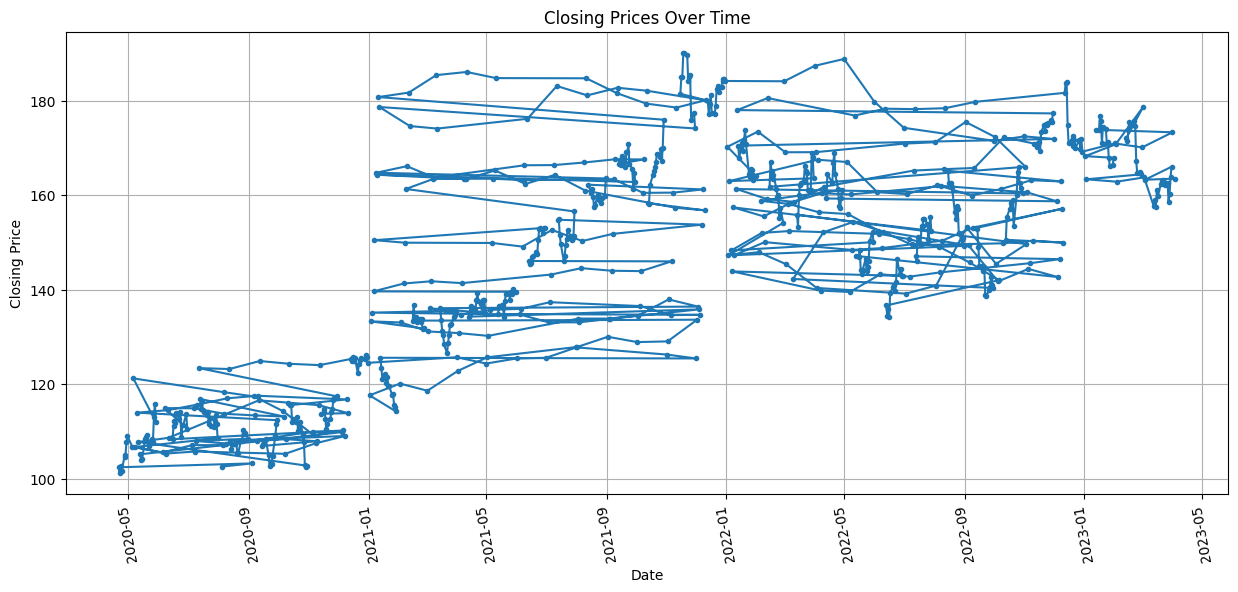

In [ ]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Adj Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=100)
plt.grid(True)
plt.show()

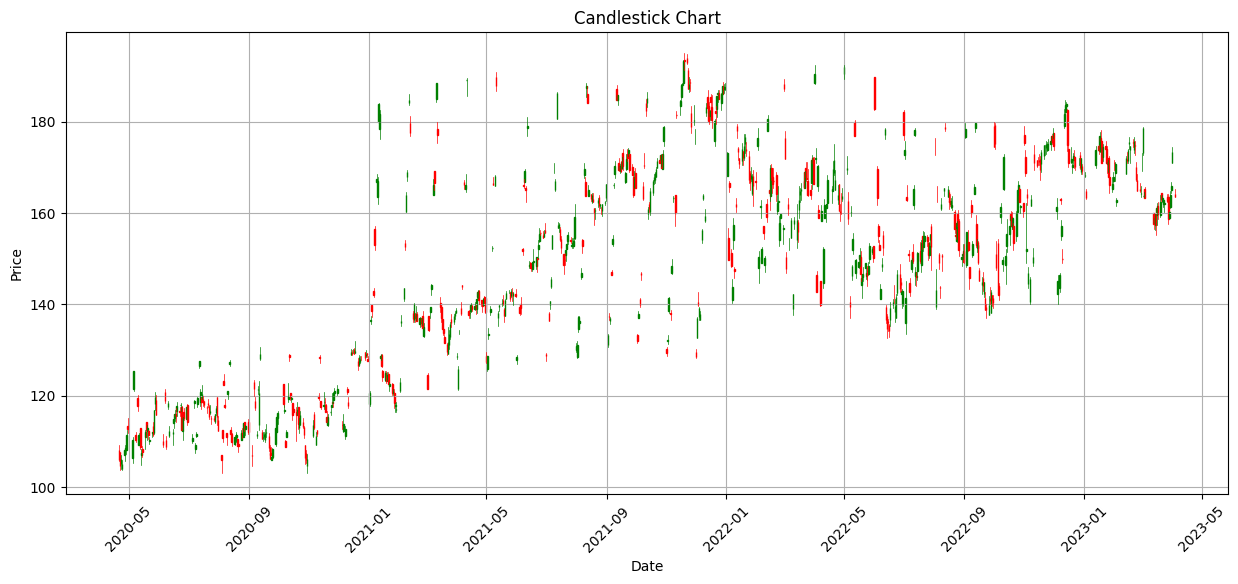

In [ ]:
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

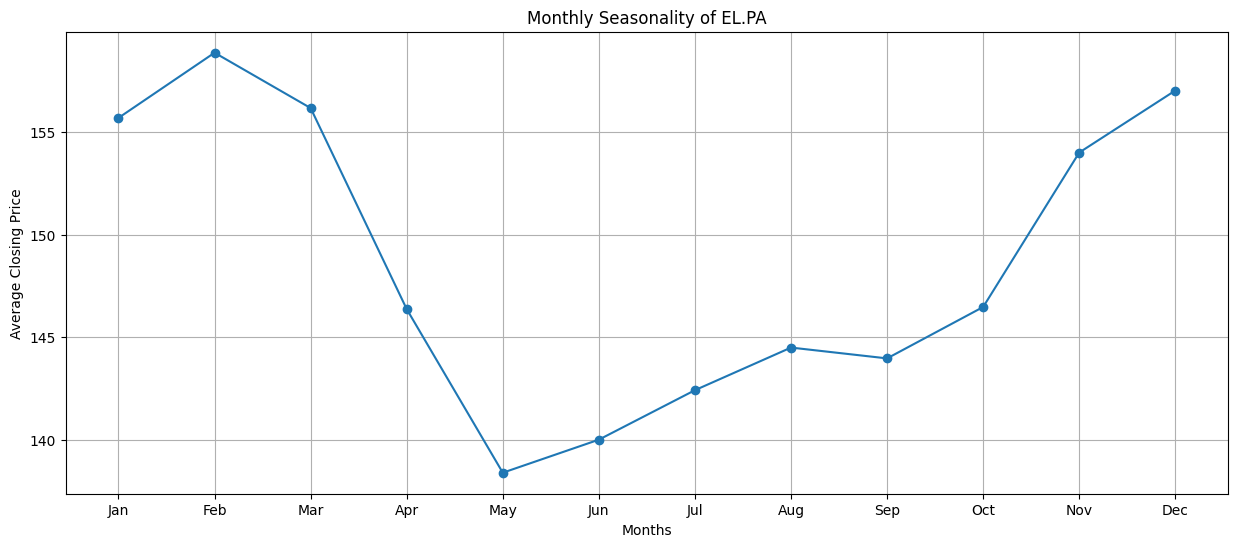

In [ ]:
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Close'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [ ]:
specific_df.head()

new_df = specific_df.reset_index()['Close']
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1, 1))

# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Define the sequence length (number of past time steps)
n_past = 60

In [ ]:
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Training set size:-
(520, 60)
(520,)


Testing set size:-
(86, 60)
(86,)


In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Defining our callbacks
checkpoints = ModelCheckpoint(filepath='my_weights.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the LSTM model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[checkpoints, early_stopping])

# Make predictions with the LSTM model
pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - loss: 0.1788 - val_loss: 0.0605
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0256 - val_loss: 0.0061
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0101 - val_loss: 0.0050
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0081 - val_loss: 0.0039
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 13

In [ ]:
# Decision Tree Model
# Reshape data for Decision Tree
X_train_dt = np.array([train_data[i - n_past:i, 0] for i in range(n_past, len(train_data))])
X_test_dt = np.array([test_data[i - n_past:i, 0] for i in range(n_past, len(test_data))])

# Train the Decision Tree model
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train_dt, y_train)

# Make predictions with the Decision Tree model
pred_dt = model_dt.predict(X_test_dt)
pred_dt = scaler.inverse_transform(pred_dt.reshape(-1, 1))



In [ ]:
# ARIMA Model
# Train the ARIMA model
model_arima = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model_arima.fit(train_data)

# Make predictions with the ARIMA model
n_test = len(test_data)
pred_arima = model_arima.predict(n_periods=n_test)
pred_arima = scaler.inverse_transform(pred_arima.reshape(-1, 1))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2477.378, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2483.376, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2481.748, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2481.718, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2484.496, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2481.170, Time=0.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.661 seconds


In [ ]:
# Ensure all predictions are of the same length
min_len = min(len(pred_lstm), len(pred_dt), len(pred_arima))
pred_lstm = pred_lstm[-min_len:]
pred_dt = pred_dt[-min_len:]
pred_arima = pred_arima[-min_len:]

# Combine predictions (simple average)
combined_pred = (pred_lstm + pred_dt + pred_arima) / 3

# Calculate RMSE for ensemble model
mse_ensemble = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1))[-min_len:], combined_pred)
rmse_ensemble = math.sqrt(mse_ensemble)
print(f'Ensemble Model RMSE: {rmse_ensemble}')


Ensemble Model RMSE: 4.443596265092386


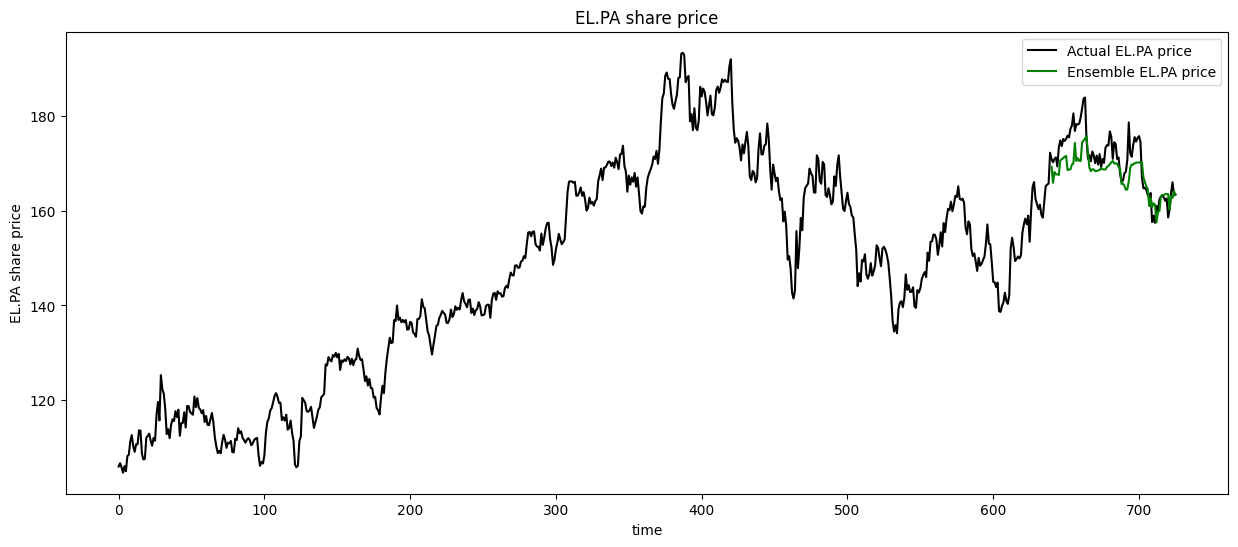

In [ ]:
ensemblePredictPlot = np.empty_like(new_df)
ensemblePredictPlot[:] = np.nan
test_start = len(new_df) - len(combined_pred)
ensemblePredictPlot[test_start:] = combined_pred.flatten()

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data), color='black', label=f"Actual {company_name} price")
plt.plot(ensemblePredictPlot, color='green', label=f"Ensemble {company_name} price")
plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()


In [ ]:

 #Future predictions
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    pred_lstm_next = model_lstm.predict(last_sequence)
    pred_dt_next = model_dt.predict(last_sequence.reshape(1, -1))
    pred_arima_next = model_arima.predict(n_periods=1)
    next_day_prediction = (pred_lstm_next + pred_dt_next + pred_arima_next.reshape(-1, 1)) / 3
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predictions for the next 10 days:
Day 1: Predicted Price = 163.33089991804687
Day 2: Predicted Price = 163.48880749762142
Day 3: Predicted Price = 163.53517412200438
Day 4: Predicted Price = 163.51457671531378
Day 5: Predicted Price = 163.46422201868697
Day 6: Predicted Price = 163.40772491573753
Day 7: Predicted Price = 163.35752347100347
Day 8: Predicted Price = 163.31879301851856
Day 9: Predicted Price = 163.29252881482773
Day 10: Predicted Price = 163.27754183662506


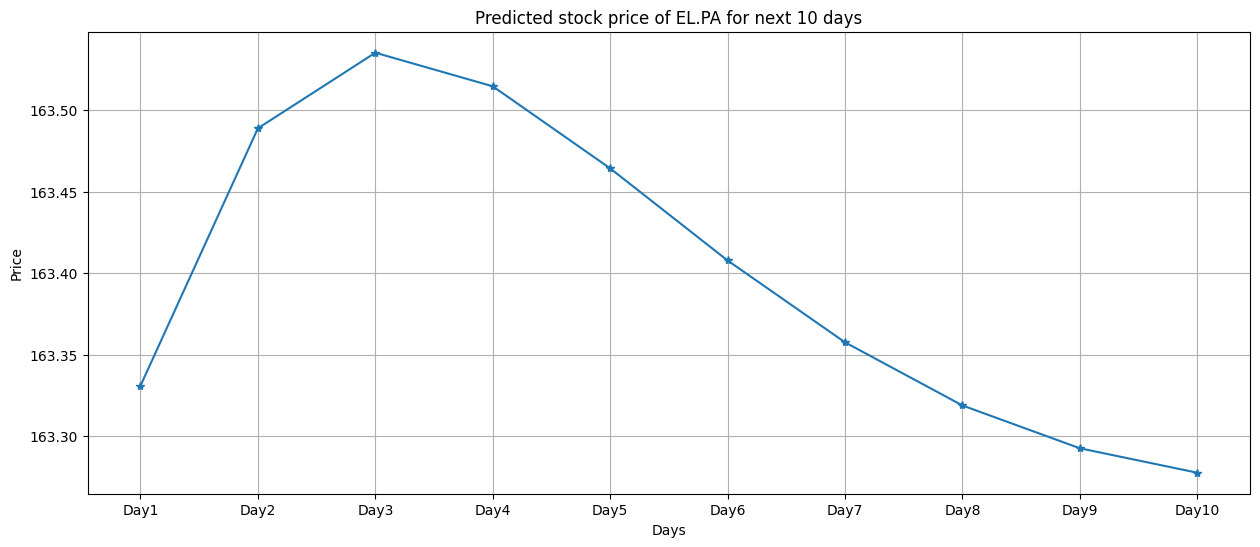

In [ ]:
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

plt.figure(figsize=(15, 6))
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()

In [ ]:
!git init


Reinitialized existing Git repository in /content/Stock-market-prediction/.git/


In [ ]:
!git checkout -b main


fatal: A branch named 'main' already exists.
